<div>
<img src="opencosmo_simple_transparent.png" width="600">
</div>

# OpenCosmo Tutorial - exploring halo profiles



In this tutorial we're going to download some data using the portal, and then use the toolkit to analyze it. As many of you are aware, I'm curious what the pressure profiles around clusters looks like in our hydro data, so let's try that out together. 

## The portal

Now navigate to Halo Query (Hydro) and select something like the following:


|Complete          |  Option |
|:------------------|:--------|
| Simulation               | SCIDAC_T001      | 
| Limit     | 1000      | 
| Step               | 624      | 
| Include Profiles| Yes      | 
| Include Galaxies| Yes      | 
| M200c high | 1e14      | 
| M200c low| 1e13      | 





<div class="alert alert-block alert-info"><b>Note: </b> Some of the options are changing quickly to make them more intuitive, if you are unsure about any of the selections to get a decent sample of halos just ask!  </div> 


In [10]:
import opencosmo as oc
dataset = oc.open("haloproperties.hdf5")
print(dataset)

OpenCosmo Dataset (length=237441)
Cosmology: FlatLambdaCDM(name=None, H0=<Quantity 67.66 km / (Mpc s)>, Om0=0.3096446816186967, Tcmb0=<Quantity 0. K>, Neff=3.04, m_nu=None, Ob0=0.04897468161869667)
First 10 rows:
block fof_halo_1D_vel_disp fof_halo_center_x ... sod_halo_sfr unique_tag
             km / s               Mpc        ... solMass / yr           
int32       float32             float32      ...   float32      int64   
----- -------------------- ----------------- ... ------------ ----------
  155            146.54573          85.66223 ...          0.0  110101650
  160            98.099335         12.240096 ...       -101.0   34916666
  193            46.026096        120.373314 ...       -101.0  179585178
  256             46.82955         11.606986 ...       -101.0   17863190
  326            43.175446         103.02338 ...       -101.0  141655660
  358             52.26482           98.2229 ...          0.0  143781714
  465             45.62393         134.22644 ...       -1

<div class="alert alert-block alert-info"><b>Tip: </b> This data is stored as astropy objects, you can directly access the cosmology and data using dataset.cosmology and dataset.data, and then inspect it as usual  </div> 

I am going to quickly have a look at all the properties we have


In [3]:
for key in dataset.data.keys():
    if 'mass' in key:
        print(key)

fof_halo_mass
sod_halo_c_acc_mass
sod_halo_c_peak_mass
sod_halo_mass
sod_halo_mass_agn
sod_halo_mass_dm
sod_halo_mass_gas
sod_halo_mass_nHI
sod_halo_mass_sfgas
sod_halo_mass_star
sod_halo_mass_wind
sod_halo_mmagn_mass


Now we've already filtered to cluster-mass objects, but let's add an extra filter, look at the first 10 objects, and reduce the data to only the columns we want

In [4]:
dataset = dataset.filter(oc.col("sod_halo_mass") > 2e13).take(10,at="random").select(["fof_halo_mass", "sod_halo_cdelta","sod_halo_mass"])


In [5]:
dataset.data

fof_halo_mass,sod_halo_cdelta,sod_halo_mass
solMass,,solMass
float32,float32,float32
25488255000000.0,3.8827114,23557694000000.0
78792060000000.0,4.3661394,71719070000000.0
43304640000000.0,4.1444035,39177530000000.0
68889795000000.0,1.8893653,54041564000000.0
22362368000000.0,4.9112616,21814632000000.0
266097990000000.0,1.5828555,253989600000000.0
72435034000000.0,4.358037,72418860000000.0
79351740000000.0,4.9899077,73865795000000.0


## Um hold up a minute...

Confused about where the website is, units, property names, how to download the toolkit? Go to the getting started tutorial where I outline all that!


## Matching up the outputs

Okay so we're going to look at a matched dataset - the haloproperties and sodproperties files you've just downloaded. These are a linked dataset, we just open it as a linked file using 
```python
data = oc.open_linked_files(halopropertyfile, haloparticlefile)
```

The sodproperties are the binned profiles and their naming is not always easy, so let's just look at a few for now. 

- sod_halo_bin_radius: radius of the bin (there are 50 bins in total for each halo)
- fof_halo_bin_tag: this tells you the halo tag
- sod_halo_bin_count: particle count in the bin
- sod_halo_bin_cdm_fraction: number 
- sod_halo_bin_gas_pthermal: thermal pressure in the bin
- sod_halo_norm_gas_YSZ: compton-y profile


<div class="alert alert-block alert-info"><b>Tip: </b> To see the rest just run data = oc.open("sodproperties.hdf5"); data.data.keys(). Remember the units are there as data.data[myproperty].unit   </div> 

We're going to open these as linked files, but then filter on only the halo properties. I'll go over quickly the filtering syntax. To filter you can use 
```python
dataset.filter(oc.col(colname)>criteria_min, oc.col(colname)==criteria_equal)
```
you can also select properties to keep using 
```python
dataset.select([property1,property2])
```
and take a random sampling of that using 
```python
dataset.take(howmany,at='random')
```

Remember that these are comoving units without any h-factors, so not quite our standard hacc units. Using these selections can really speed this up for large datasets so remember to pare down the list of columns you need. 

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# here the sodproperties are the binned profiles, and the haloproperties are just the standard property file. 
# these are linked as you've requested them from the website at the same time. 
data = oc.open_linked_files("haloproperties.hdf5", "sodproperties.hdf5")

# cut here is in Msun - remember this is a factor of h different from the portal 
data = data.filter(oc.col("sod_halo_mass") > 2e14, oc.col("sod_halo_mass") < 1e16)



Now let's try plotting the pressure profiles against the Arnaud profile (as implemented by ccl)

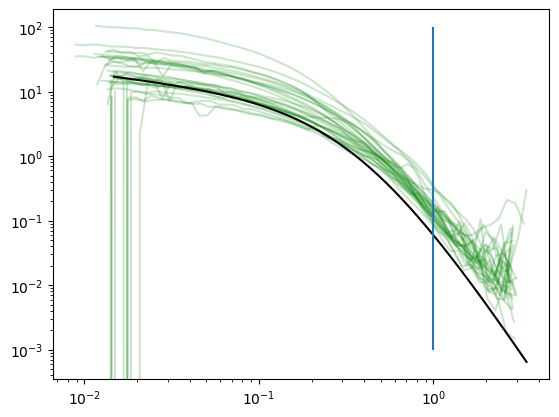

In [27]:
import pyccl as ccl
from pyccl.halos.profiles import HaloProfilePressureGNFW
mass_def = ccl.halos.MassDef500c
cosmo = ccl.Cosmology(Omega_c=0.26067, Omega_b=0.0489, h=0.6766, sigma8=0.8102, n_s=0.9665)

ptherm ='sod_halo_bin_gas_pthermal' # thermal pressure
ysz = 'sod_halo_bin_norm_gas_YSZ' # YSZ profile 

plt.figure()
masses=[]
for halo_properties, halo_bins in data.objects():
    masses.append(halo_properties['sod_halo_M500c'].value) # getting M500c as that's used in the Arnaud profile
    rad = halo_properties['sod_halo_radius'].value
    #units are keV / (comoving cm)^3, h values have been corrected by unit conversions
    plt.plot(halo_bins.data['sod_halo_bin_radius'].data[0]/rad, halo_bins.data[ptherm].data[0]*1.e3,'g',alpha=0.2)

# Default CCL values - generally I think these are meant to align with Planck13 profiles
prof_ccl = HaloProfilePressureGNFW(mass_def = mass_def)
profile = prof_ccl.real(cosmo,halo_bins.data['sod_halo_bin_radius'].data[0], np.mean(masses), 1.0) # ev/cm^3
plt.loglog(halo_bins.data['sod_halo_bin_radius'].data[0]/rad, profile,'k')
plt.vlines(1.0,1.e-3,100)

plt.yscale('log')
plt.xscale('log')
plt.show()

### Challenges

- Do a grid search for optimal gNFW parameters for this sim
- Help me understand - explore parameter choices from other simulations or other pressure profiles, do those match better?
- Find the profile of a halo, and the particles of that same halo, look at the density profile and find any oddities, then look at the particles and work out what it is
- Get galaxy locations within the halo and compare to the particles, see how the sub-structures line up with the galaxy positions